<a href="https://colab.research.google.com/github/Strojove-uceni/2024-final-michal-aaron/blob/main/wildfire_spread__demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Wildfire Spread Prediction

*Autor:* Michal Bohatý

*Abstrakt:*

Lesní požáry jsou jednním z přírodních jevů, se kterými se lidstvo musí každoročně vypořádávat. V porovnání s jinými katastorfami naštěstí patří k těm méně nebezpečným, přesto si každoročně vyžádají stovky lidských životů a způsobí nezanedbatelné škody na majetku. Předpověď jejich šíření může být tedy klíčovou pro minimalizci jejich následků. V současnosti máme k dispozici stále více dat z dálkového průzkumu Země, které k tomuto účelu můžeme použít. Tento projekt se zaměřil na vytvoření modelu pro predikci šíření požárů do následujícího dne za použití satelitních dat a neuronové sítě typu U-Net. Model zpracovává různé vstupní proměnné, jako jsou meteorologické podmínky, topografie a masky požárů, aby odhadl jejich šíření. Přestože dosažené výsledky naznačují potenciál využití této metody, predikce jsou omezené velkou náhodností v šíření požárů a limity datasetu, zejména absencí dlouhodobějších dat.



###Dataset

Pro trénování a validaci modelu používáme dataset [Next Day Wildfire Spread](https://www.kaggle.com/datasets/fantineh/next-day-wildfire-spread/data), který obsahuje data z let 2012 až 2020 z USA. Dataset čítá celkem 18 445 vzorků, každý z nich zachycuje oblast o rozloze 64 km × 64 km s prostorovým rozlišením 1 km na pixel. Pro každou oblast máme k dispozici tyto informace:


*   maska výskytu požáru v aktuálním dni,
*   maska výskytu požáru v následujícím dni,
*   výškový profil oblasti,
*   směr větru,
*   rychlost větru,
*   minimální teplota,
*   maximální teplota,
*   vlhkost,
*   srážky,
*   index sucha,
*   vegetace (normalizovaný rozdílový vegetační index – NDVI),
*   hustota zalidnění,
*   energetická uvolňovací složka – ERC (množství energie, která se může uvolnit hořením)

Masky požáru obsahují hodnoty:

* 0 = žádný požár
* 1 = požár
* -1 = nelze klasifikovat (např. kvůli oblačnosti)

Náš model bude klasifikovat pouze do dvou tříd (0 a 1), při vyhodnocování tedy přiřadíme neklasifikované pixely do skupiny 0. Ukázka dat je na obrázku níže.



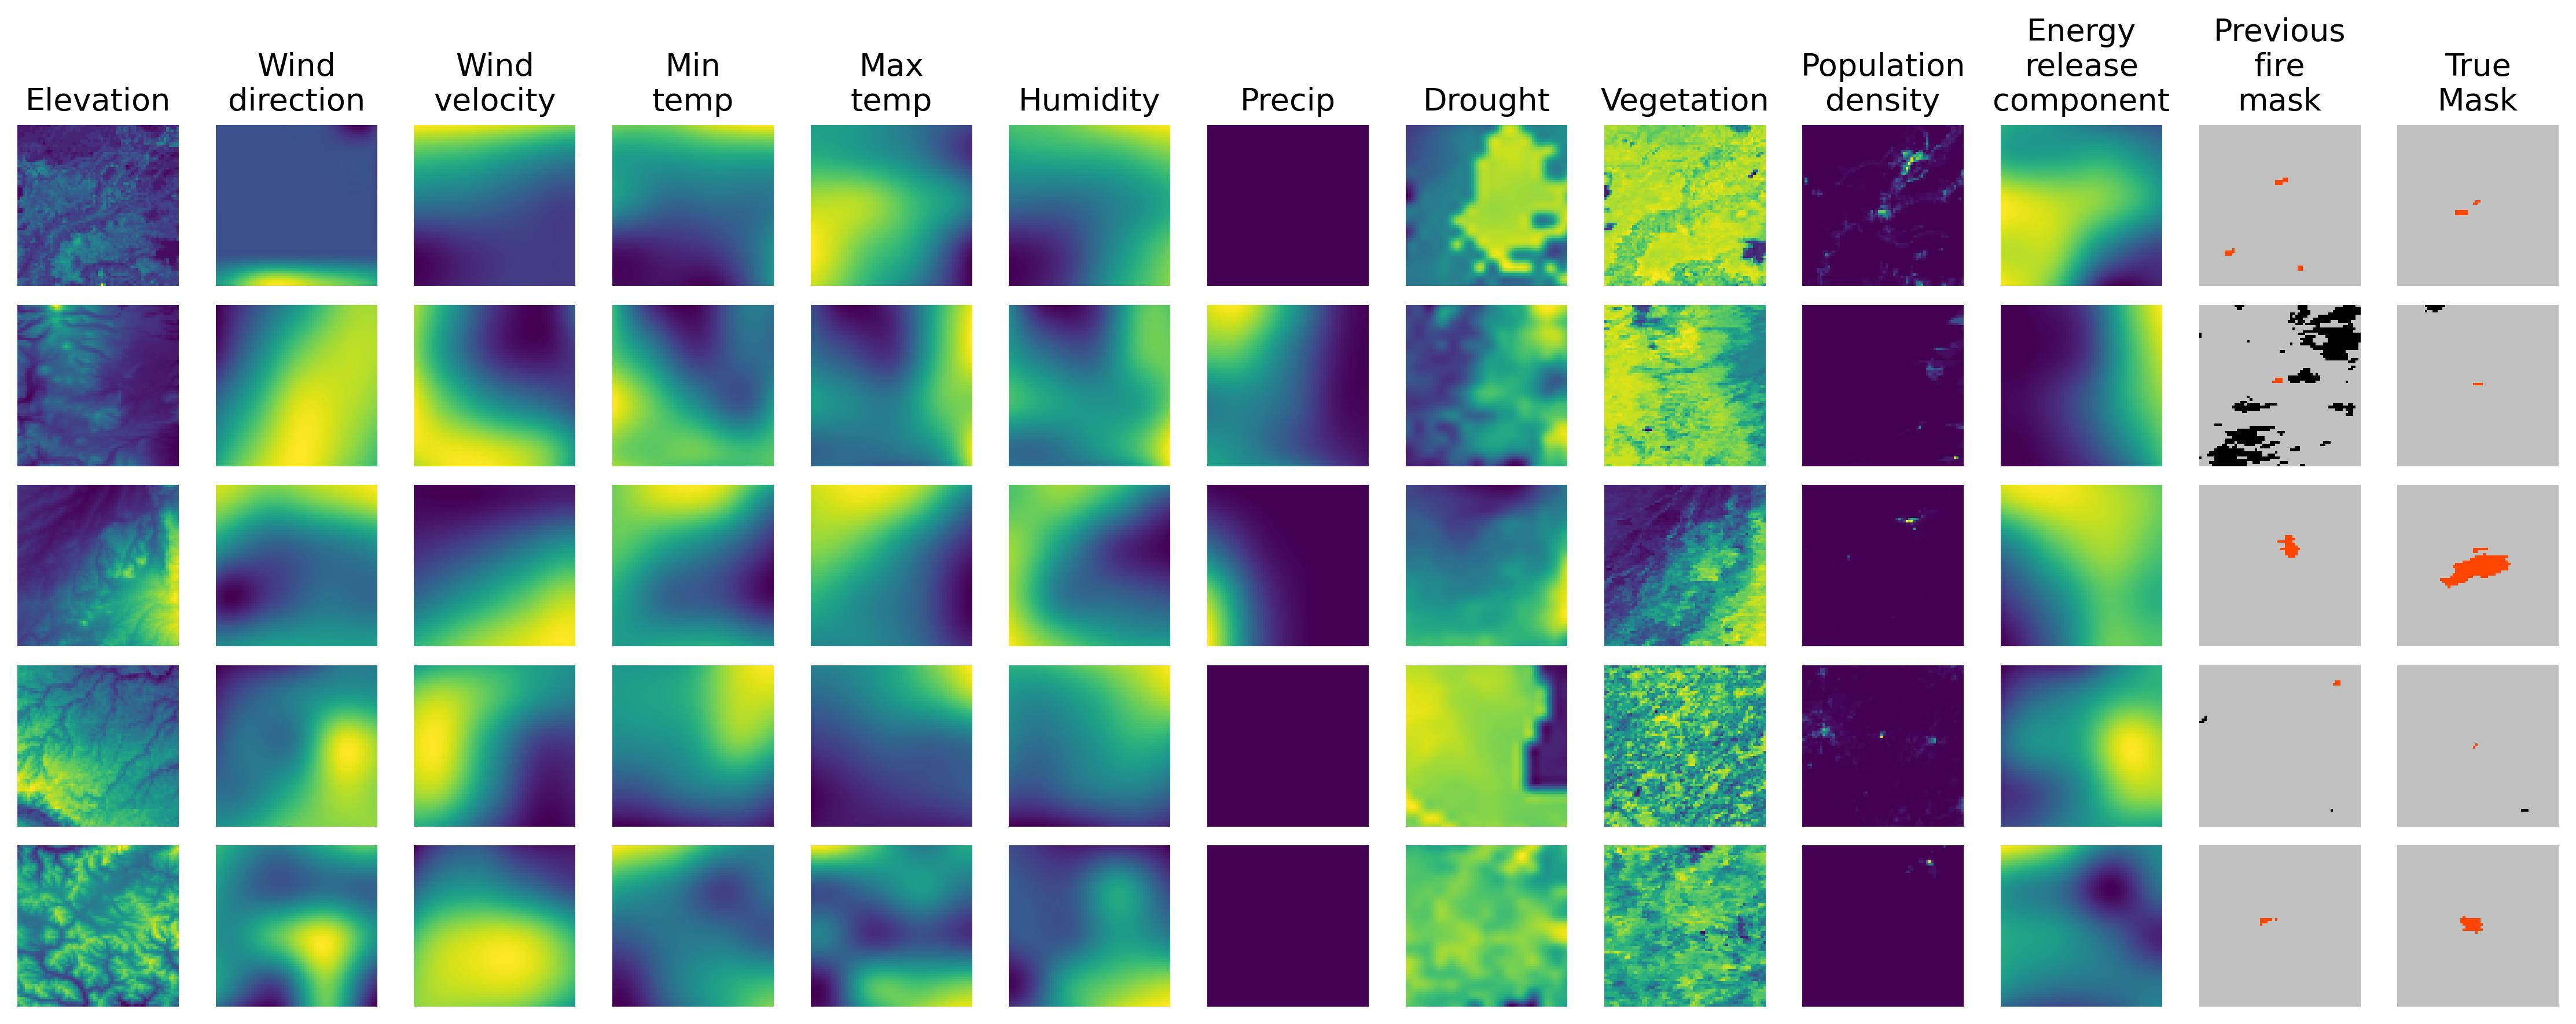


I z těchto něolika obrázků si lze všimnout, že data bývají přibližně centrovaná kolem požárů, které se snažíme predikovat. Z tohoto důvodu používáme náhodné ořezávání dat vstupujících do modelu na velikost 32x32. Rádi bychom zde také ocenili profesionalitu, s jakou je dataset zpracovaný. Nejsou v něm žádné chybějící hodnoty a je k němu k dispozici kód pro načítání dat a jejich normalizaci.

### Architektura modelu

Pro predikci jsme použili neuronovou síť typu [U-Net](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28), která je navržena pro segmentační úlohy. Model kombinuje encoder-dekoder strukturu se skip connections, které umožňují přenášet informace o různých úrovních detailů mezi vrstvami.

| **Název vrstvy**     | **Vstupní kanály** | **Výstupní kanály** | **Rozlišení** | **Popis**                                                                            |
|-----------------------|--------------------|---------------------|---------------|--------------------------------------------------------------------------------------|
| **Vstupní vrstva**    | 12                | 64                  | 32x32         | Dvojitá konvoluce s 3x3 jádrem a paddingem.                  |
| **První vrstva encoderu**| 64                | 128                 | 16x16         | Max-pooling, dvojitá konvoluce. |
| **Druhá vrstva encoderu**| 128               | 256                 | 8x8           | Max-pooling, dvojitá konvoluce.                           |
| **Bottleneck**        | 256               | 512                 | 4x4           | Max-pooling, dvojitá konvoluce.                                   |
| **První vrstva decoderu**| 512               | 256                 | 8x8           | Upsampling pomocí transponované konvoluce, připojení skip connections, dvojitá konvoluce. |
| **Druhá vrstva decoderu**| 256               | 128                 | 16x16         | Upsampling, skip connections, dvojitá konvoluce. |
| **Výstupní vrstva**   | 128               | 64                  | 32x32         | Upsampling, skip connections, dvojitá konvoluce.               |
| **Finální výstup**    | 64                | 1                   | 32x32         | Poslední konvoluční vrstva, produkuje logity pro výstupní masku. |


Jelikož dataset je velmi nevyvážený z hlediska zastoupení obou tříd, používáme pro optimalizaci *Dice loss*, díky které můžeme dosáhnout vyváženého poměru mezi *precision* a *recall*.

##Implementace

Pokud budete chtít následující kód spouštět, přidejte si tuto složku s daty a checkpointem na váš google disk: https://drive.google.com/drive/folders/1RwHY9O-wtmivHxXTsdG7lVcnrogIhHzE?usp=sharing

###Instalace a import balíčků

In [ ]:
%pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 17.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader, IterableDataset, Dataset
from torchmetrics.classification import BinaryPrecision, BinaryRecall
from torchvision.transforms.v2 import Compose, RandomCrop, CenterCrop, RandomHorizontalFlip, RandomRotation

from pytorch_lightning.loggers.wandb import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import wandb

import tensorflow as tf
import re
from typing import Dict, List, Optional, Text, Tuple
import random

import os
from google.colab import drive

import matplotlib.pyplot as plt
from matplotlib import colors

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_files = '/content/drive/MyDrive/SU2/data/next_day_wildfire_spread_train*'
eval_files = '/content/drive/MyDrive/SU2/data/next_day_wildfire_spread_eval*'
test_files = '/content/drive/MyDrive/SU2/data/next_day_wildfire_spread_test*'

Protože budeme chtít použít pomocnou funkci pro načítání datasetu, naklonujeme si původní repo do relace v Colabu.

In [ ]:
!git clone https://github.com/Strojove-uceni/2024-final-michal-aaron.git

Cloning into '2024-final-michal-aaron'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 15 (delta 2), reused 9 (delta 1), pack-reused 4 (from 1)
Receiving objects: 100% (15/15), 941.04 KiB | 2.45 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
import sys
sys.path.append('/content/2024-final-michal-aaron')
from src import data_loader

data_loader obsahuje kód od autorů datasetu pro jeho načtení a předzpracování.

###Načtení dat

In [84]:
train_dataset = data_loader.get_dataset(
      train_files,
      data_size=64,
      sample_size=64,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

eval_dataset = data_loader.get_dataset(
      eval_files,
      data_size=64,
      sample_size=64,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

test_dataset = data_loader.get_dataset(
      test_files,
      data_size=64,
      sample_size=64,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

In [ ]:
#print(f"Train dataset size: {len(list(train_dataset))}") #takes some time for large datasets
#print(f"Eval dataset size: {len(list(eval_dataset))}")
print(f"Test dataset size: {len(list(test_dataset))}")

Test dataset size: 1689


###Definice modelu

Zde si představíme přesnou implementaci dříve popsaného modelu pomocí balíčku PyTorch Lightning. Nejprve si definujeme dvojitou konvoluci, kterou budeme používat v jendotlivých vrstvách U-Netu.

In [ ]:
# Double convolution used in U-Net layers
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
        )

    def forward(self, x):
        return self.conv(x)


Dále sestavíme základní kostru U-Netu, sekládající se z encoderu (down-sampling), decoderu (up-sampling) a skip-connections přenášejících informace z encoderu do decoderu.

In [ ]:
# Define U-Net model
class UNET(nn.Module):
    def __init__(self, in_channels=12, out_channels=1, features=[64, 128, 256], dropout=0.0):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down-sampling layers
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature, dropout))
            in_channels = feature

        # Up-sampling layers
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature * 2, feature, dropout))

        # Bottleneck layer
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2, dropout)

        # Final convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Pass through the down-sampling layers
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Pass through the up-sampling layers
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            # Resize if shapes do not match
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            # Concatenate with skip connection
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        # Final convolution
        return self.final_conv(x)

Jako ztrátovou funci budeme používat Dice loss, založenou na podobném principu jako IoU (intersection over union).

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        # Flatten tensors to compute intersection and union
        preds = preds.view(-1)
        targets = targets.view(-1)

        # Compute intersection and union
        intersection = (preds * targets).sum()
        dice_coeff = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)

        # Return Dice loss (1 - Dice coefficient)
        return 1 - dice_coeff

Nyní už můžeme sestavit samotný PyTorch Ligthning modul, který zajistí mimo jiné trénování sítě.

In [ ]:
class UNETLightning(pl.LightningModule):
    def __init__(self, in_channels=12, out_channels=1, features=[128, 256, 512], threshold=0.5, learning_rate=1e-3, dropout=0.0):
        """
        PyTorch Lightning wrapper for U-Net.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            features (list): List of feature sizes for the encoder/decoder.
            threshold (float): Threshold for binary segmentation.
            learning_rate (float): Learning rate for the optimizer.
            dropout (float): Probability of a dropout.
        """
        super(UNETLightning, self).__init__()
        self.save_hyperparameters()  # Save hyperparameters for logging and reproducibility
        self.unet = UNET(in_channels=in_channels, out_channels=out_channels, features=features, dropout=dropout)
        self.loss_fn = DiceLoss()  # Use Binary Cross-Entropy Loss
        self.precision = BinaryPrecision(threshold=threshold)
        self.recall = BinaryRecall(threshold=threshold)
        self.threshold = threshold
        self.learning_rate = learning_rate

    def forward(self, x):
        # Pass through U-Net
        return self.unet(x)

    def _shared_step(self, batch, stage):
        x, y = batch
        preds = torch.sigmoid(self(x))
        # Calculate loss
        loss = self.loss_fn(preds, y)

        # Calculate precision and recall
        precision = self.precision(preds, y)
        recall = self.recall(preds, y)

        # Log metrics
        self.log(f"{stage}_loss", loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log(f"{stage}_precision", precision, prog_bar=True, on_epoch=True, on_step=False)
        self.log(f"{stage}_recall", recall, prog_bar=True, on_epoch=True, on_step=False)

        return loss

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, stage="train")

    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, stage="val")

    def test_step(self, batch, batch_idx):
        return self._shared_step(batch, stage="test")

    def configure_optimizers(self):
        # Use the configurable learning rate
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

Jako poslední potřebujeme modul pro načítání dat. Zde definujeme potřebné transformace, jako je random cropping a převedení -1 na 0 v masce požáru.

In [85]:
class FireDataset(Dataset):
    def __init__(self, tf_dataset, transform=None):
        self.tf_dataset = list(tf_dataset)
        self.crop_size = crop_size
        self.transform = transform

    def __len__(self):
        return len(self.tf_dataset)

    def __getitem__(self, idx):
        x, y = self.tf_dataset[idx]
        x = tf.convert_to_tensor(x).numpy()
        y = tf.convert_to_tensor(y).numpy()

        # Convert to PyTorch tensors and permute to CHW
        x = torch.tensor(x, dtype=torch.float32).permute(2, 0, 1)  # HWC -> CHW
        y = torch.tensor(y, dtype=torch.float32).permute(2, 0, 1)

        # Transform -1 in y to 0
        y = torch.where(y == -1, torch.tensor(0.0, device=y.device), y)

        if self.transform:
            stacked = torch.cat((x, y), dim=0)  # Combine x and y for joint transform
            stacked = self.transform(stacked)
            x, y = stacked[:x.shape[0]], stacked[x.shape[0]:]  # Split back into x and y

        return x, y


class FireDataModule(pl.LightningDataModule):
    def __init__(self, train_dataset, test_dataset, eval_dataset, crop_size=64, batch_size=32):
        """
        PyTorch Lightning DataModule for fire data.

        Args:
            train_dataset: TensorFlow dataset for training.
            test_dataset: TensorFlow dataset for testing.
            eval_dataset: TensorFlow dataset for evaluation.
            batch_size: Batch size for DataLoader.
        """
        super().__init__()
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.eval_dataset = eval_dataset
        self.batch_size = batch_size
        self.crop_size = crop_size

        self.train_transform = Compose([
          RandomCrop(self.crop_size),
          #RandomHorizontalFlip(p=0.5),
        ])
        self.test_transform = Compose([
          CenterCrop(self.crop_size),
        ])

    def setup(self, stage=None):
        """
        Setup datasets for training, validation, and testing.

        Args:
            stage: Current stage (e.g., 'fit', 'test').
        """
        # Convert TensorFlow datasets to PyTorch-compatible datasets
        self.train_data = FireDataset(self.train_dataset, transform=self.train_transform)
        self.test_data = FireDataset(self.test_dataset, transform=self.test_transform)
        self.eval_data = FireDataset(self.eval_dataset, transform=self.test_transform)

    def train_dataloader(self):
        """Returns the DataLoader for training."""
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def test_dataloader(self):
        """Returns the DataLoader for testing."""

        return DataLoader(self.test_data, batch_size=self.batch_size)

    def val_dataloader(self):
        """Returns the DataLoader for evaluation."""
        return DataLoader(self.eval_data, batch_size=self.batch_size)

###Načtení natrénovaného modelu

Samotné trénování modelu probíhalo pomocí notebooku wildfire_spread_training, kromě spuštění trénování ale neobsahuje žádný podstatný kód, který by zde nebyl prezentován. My si už pouze načteme natrénovaný model, aby si každý zájemce mohl sám projít predikce pro libovolné množství dostupných dat.

In [86]:
#hyperparameters
batch_size = 16
crop_size = 64
learning_rate = 1e-3
dropout = 0.0
features = [64, 128, 256, 512]

model = UNETLightning(features=features, threshold = 0.5, learning_rate=learning_rate, dropout=dropout)
data_module = FireDataModule(train_dataset=train_dataset, test_dataset=test_dataset, eval_dataset=eval_dataset, crop_size=crop_size, batch_size=batch_size)

model = UNETLightning.load_from_checkpoint("/content/drive/MyDrive/SU2/crop64.ckpt")
model.eval()

UNETLightning(
  (unet): UNET(
    (ups): ModuleList(
      (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Dropout(p=0.0, inplace=False)
          (4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (6): ReLU(inplace=True)
          (7): Dropout(p=0.0, inplace=False)
        )
      )
      (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
      (3): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runni

###Vizualizace

Pokud si chcete sami prohlédnout výsledky modelu na testovacích datech, máte tak možnost učinit v následujících buňkách. Nejprve si z datasetu vytvoříme iterátor, v dalších buňkách pak skrze něj můžeme data procházet opakovaným spouštěním buňek. První z buňek zobrazuje kromě predikce modelu také všechna vstupní data, druhá pouze masky požárů.

In [ ]:
dataset_iter = iter(test_dataset)

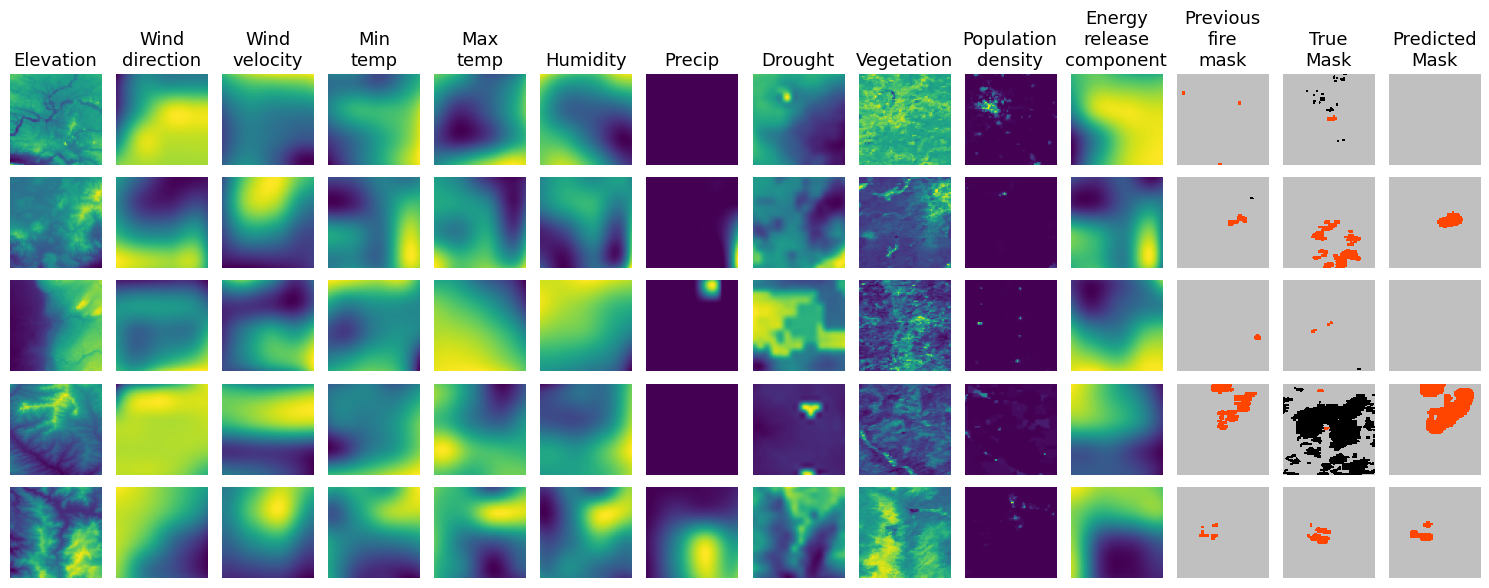

In [ ]:
NUM_EXAMPLES = 5  # Number of examples to visualize

# Define constants for visualization
TITLES = [
    'Elevation', 'Wind\ndirection', 'Wind\nvelocity', 'Min\ntemp', 'Max\ntemp',
    'Humidity', 'Precip', 'Drought', 'Vegetation', 'Population\ndensity',
    'Energy\nrelease\ncomponent', 'Previous\nfire\nmask', 'Fire\nmask'
]
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

# Fetch data (unbatched)
examples = [next(dataset_iter) for i in range(NUM_EXAMPLES)]  # Collect NUM_EXAMPLES individual examples
inputs = torch.stack([torch.tensor(example[0].numpy(), dtype=torch.float32).permute(2, 0, 1) for example in examples])  # Convert and stack inputs
labels = torch.stack([torch.tensor(example[1].numpy(), dtype=torch.float32).permute(2, 0, 1) for example in examples])  # Convert and stack labels

# Move model and inputs to the same device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = inputs.to(device)
labels = labels.to(device)

# Generate predictions
predictions = []
for i in range(NUM_EXAMPLES):
  inputs_i = inputs[i].unsqueeze(0)  # Add batch dimension
  with torch.no_grad():
      predictions.append((model(inputs_i) > 0.5).float())  # Apply sigmoid activation

# Visualize results
fig = plt.figure(figsize=(15, 6))
predictions = torch.cat(predictions, dim=0)  # Stack predictions for visualization

for i in range(NUM_EXAMPLES):
    for j in range(inputs.shape[1] + 2):  # Including labels and predictions
        plt.subplot(NUM_EXAMPLES, inputs.shape[1] + 2, i * (inputs.shape[1] + 2) + j + 1)
        if i == 0:
            if j < inputs.shape[1]:
                plt.title(TITLES[j], fontsize=13)
            elif j == inputs.shape[1]:
                plt.title("True\nMask", fontsize=13)
            else:
                plt.title("Predicted\nMask", fontsize=13)

        if j < inputs.shape[1] - 1:
            # Visualization for input features
            plt.imshow(inputs[i, j, :, :].cpu().numpy(), cmap='viridis')
        elif j == inputs.shape[1] - 1:
            # Visualization for input fire mask
            plt.imshow(inputs[i, j, :, :].cpu().numpy(), cmap=CMAP, norm=NORM)
        elif j == inputs.shape[1]:
            # Visualization for true mask (labels)
            plt.imshow(labels[i, 0, :, :].cpu().numpy(), cmap=CMAP, norm=NORM)
        else:
            # Visualization for predicted mask
            plt.imshow(predictions[i, 0, :, :].cpu().numpy(), cmap=CMAP, norm=NORM)
        plt.axis('off')

plt.tight_layout()
plt.show()

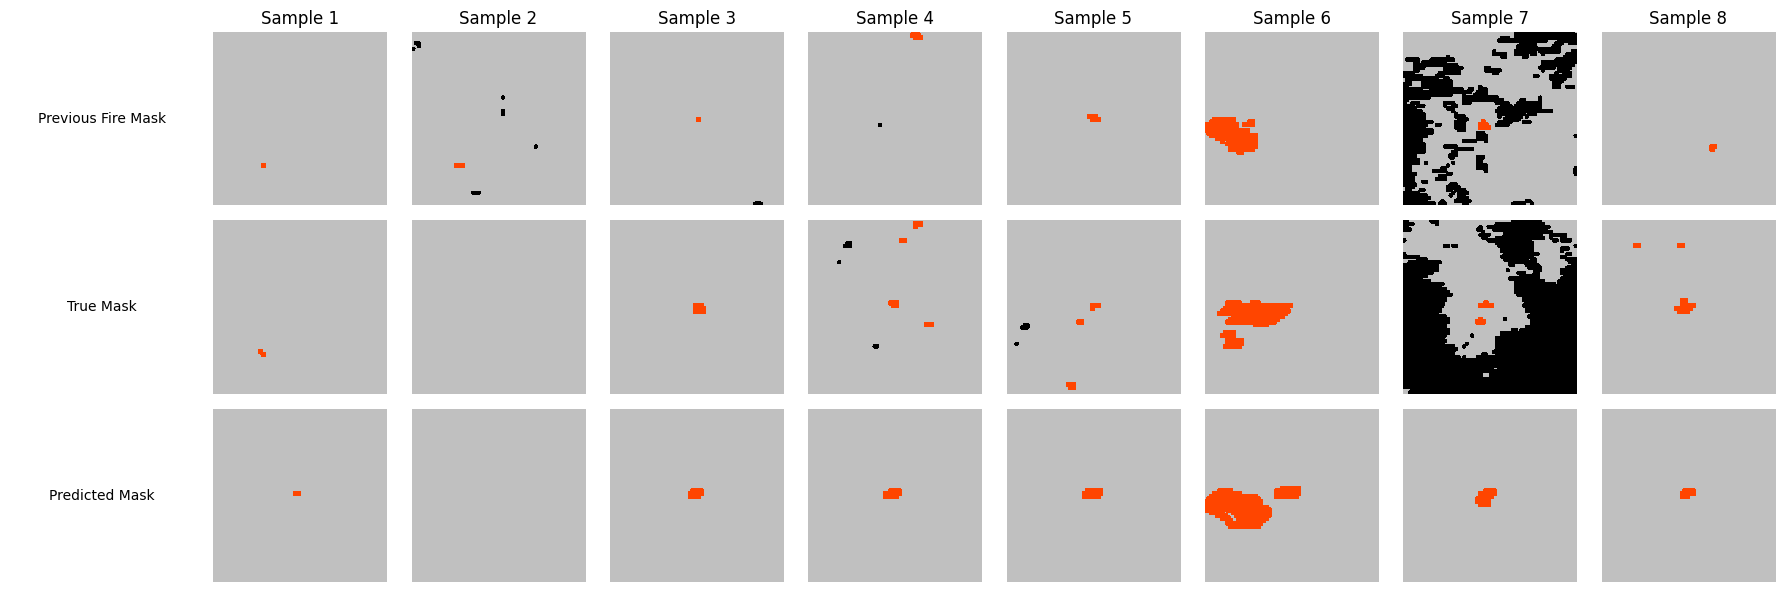

In [103]:
NUM_EXAMPLES = 8
fig_width = 2 * NUM_EXAMPLES + 2  # Add extra space for the row titles
fig_height = 6  # Fixed height for three rows: Previous Fire Mask, True Mask, Predicted Mask

# Create a figure and axes grid
fig, axes = plt.subplots(3, NUM_EXAMPLES + 1, figsize=(fig_width, fig_height))

# Titles for the rows
row_titles = ["Previous Fire Mask", "True Mask", "Predicted Mask"]

examples = [next(dataset_iter) for i in range(NUM_EXAMPLES)]  # Collect NUM_EXAMPLES individual examples
inputs = torch.stack([torch.tensor(example[0].numpy(), dtype=torch.float32).permute(2, 0, 1) for example in examples])  # Convert and stack inputs
labels = torch.stack([torch.tensor(example[1].numpy(), dtype=torch.float32).permute(2, 0, 1) for example in examples])  # Convert and stack labels

# Move model and inputs to the same device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = inputs.to(device)
labels = labels.to(device)

# Generate predictions
predictions = []
for i in range(NUM_EXAMPLES):
    inputs_i = inputs[i].unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        predictions.append((model(inputs_i) > 0.5).float())  # Apply sigmoid activation

# Concatenate predictions for easier visualization
predictions = torch.cat(predictions, dim=0)

# Visualize results
for i in range(3):  # Three rows: Previous Fire Mask, True Mask, Predicted Mask
    for j in range(NUM_EXAMPLES + 1):  # Extra column for row titles
        ax = axes[i, j]  # Access subplot

        if j == 0:
            # Add row titles in the first column
            ax.text(
                0.5, 0.5, row_titles[i], fontsize=10, ha='center', va='center'#, rotation=90
            )
            ax.axis('off')  # No plot for title cells
        else:
            # Plot the data in subsequent columns
            if i == 0:
                # Previous fire mask
                ax.imshow(inputs[j - 1, -1, :, :].cpu().numpy(), cmap=CMAP, norm=NORM)
            elif i == 1:
                # True mask
                ax.imshow(labels[j - 1, 0, :, :].cpu().numpy(), cmap=CMAP, norm=NORM)
            elif i == 2:
                # Predicted mask
                ax.imshow(predictions[j - 1, 0, :, :].cpu().numpy(), cmap=CMAP, norm=NORM)

            ax.axis('off')

            if i == 0:
                # Add column titles for the first row
                ax.set_title(f"Sample {j}", fontsize=12)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('predicted_mask.jpg', dpi=300)  # Save the figure
plt.show()  # Display the figure

##Výsledky

Nejprve se zaměříme na analýzu výsledků z námi vybraného modelu a jeho limitů. Poté si okomentujeme také samotný výběr modelu.

Na základě analýzy dosažených výsledků jsme zjistili, že predikce šíření požárů je možná pouze s omezenou přesností. Hlavní výzvou je především charakter dat: v mnoha případech dataset obsahuje požáry, které pokrývají pouze několik pixelů, přičemž tyto požáry často vykazují velké změny své polohy mezi sledovanými dny (např. vzorky 3, 7 a 8 na obrázku níže). Je pravděpodobné, že takové změny jsou způsobeny tím, že se nemusí jednat o jeden požár, ale o více na sobě nevávislých, kde jeden zanikne a druhý se objeví. Predikce takových jevů je velmi obtížná a od modelu lze jen těžko očekávat, že by je dokázal přesně zachytit. Na stejný problém narazíme pokud požár vznikne mezi oběma sledovanými dny.

U větších požárů, které pokrývají více pixelů, už model vykazuje lepší výsledky. Predikce zde alespoň zhruba odpovídají skutečnému šíření požáru. Nicméně, pokud bychom chtěli model použít v praktických aplikacích, očekávali bychom od něj vyšší úroveň přesnosti.

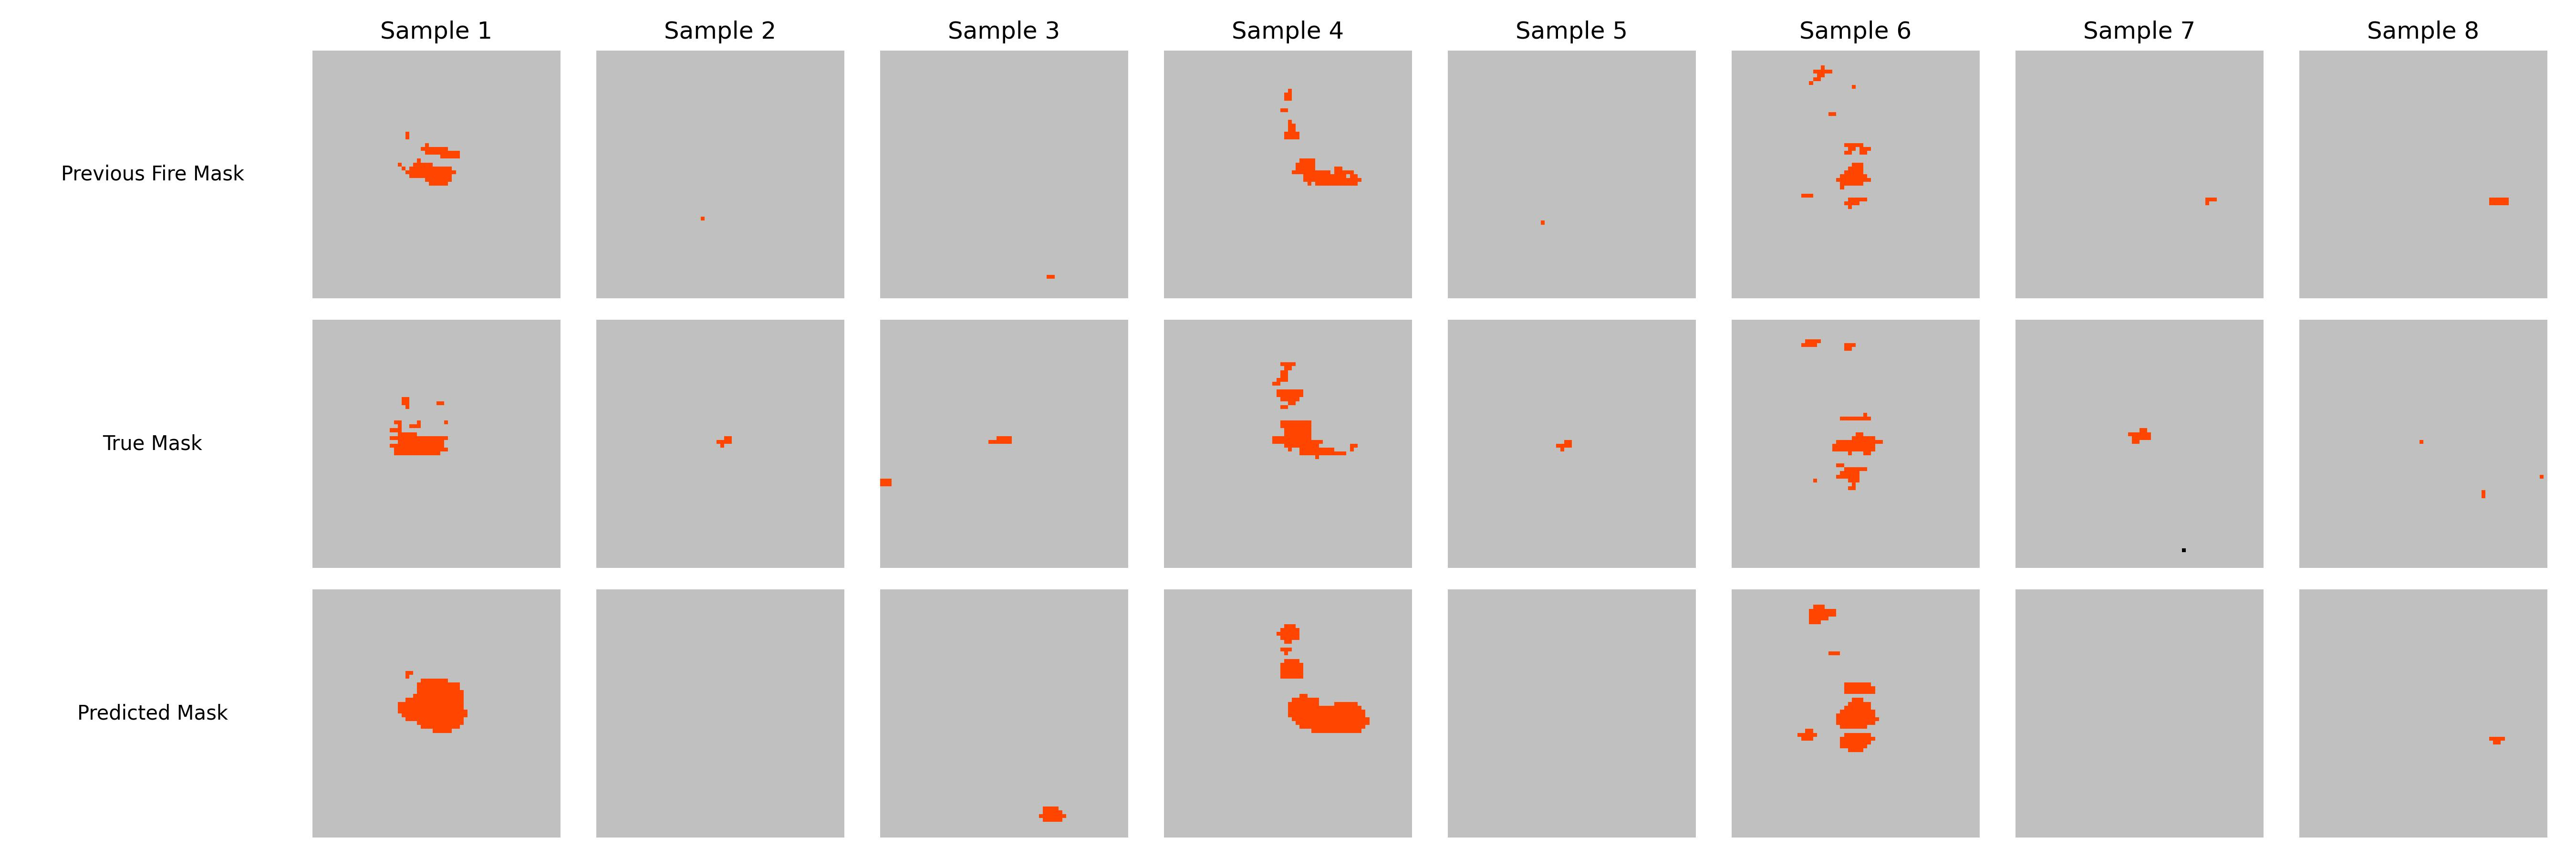

###Porovnání s jednoduchou strategií


Abychom posoudili efektivitu modelu, porovnali jsme jeho výkon s jednoduchou strategií, která používá masku požáru z předešlého dne jako predikci. Výsledky ukazují, že co se týče čistě *precision*, je použití masky předchozího dne dokonce o něco lepší. Na druhou stranu, pokud zohledníme i *recall* a vypočítáme F1 skóre, které kombinuje obě tyto statistiky, náš model dosahuje lepších výsledků.

| Model            | Precision | Recall | F1 Score |
|------------------|-----------|--------|----------|
| U-net          | 0.323      | 0.436   | 0.371     |
| Previous fire mask          | 0.353      | 0.272   | 0.307     |


Tento výsledek naznačuje, že náš model přináší určitou přidanou hodnotu, zejména ve schopnosti zachytit širší spektrum požárů, které by jinak maska z předchozího dne nepředpověděla.

###Vliv proměnných


Další otázkou bylo, zda náš model využívá i jiné vstupní proměnné než pouze masku požáru z předchozího dne, nebo zda ostatní proměnné nemají významný vliv. Pro odpověď jsme provedli experiment, ve kterém jsme model naučili pouze s maskou požáru jako vstupní proměnnou.

| Model            | Precision | Recall | F1 Score |
|------------------|-----------|--------|----------|
| U-net          | 0.323      | 0.436   | 0.371     |
| U-net mask only          | 0.291      | 0.399   | 0.336     |

Výsledky ukazují, že odstranění ostatních proměnných vedlo ke zhoršení predikce. To naznačuje, že další vstupní proměnné (vítr, teplota, nadmořská výška...) mají nezanedbatelný vliv na kvalitu predikce.

###Limity modelu a možnosti zlepšení

Pro vytvoření modelu, který by byl užitečný v reálných aplikacích, by bylo potřeba výrazně pozměnit dataset. Především:

* **Vícedenní data:** Dataset by měl zahrnovat požáry sledované během více po sobě jdoucích dní, aby model mohl lépe pochopit dynamiku jejich šíření. Současná situace, kdy model predikuje pouze na základě jednoho předchozího dne, jeho schopnosti v tomhle směru výrazně omezuje.

* **Vyšší rozlišení dat:** Šíření požárů mohou ovlivňovat i krajinné prvky, které jsou menší než současné rozlišení 1 km na pixel. Detaily jako menší místa bez porostu, vodní toky nebo silnice, které mohou požárům bránit v šíření, by mohly významně zlepšit predikční schopnosti modelu.

Samozřejmě pro vícedenní data bychom pak museli volit odlišnou architekturu modelu, která je schopná zpracovávat časové sekvence.

###Volba modelu



Nyní se podívajme na různé hyperparametry, přes které jsme se snažili naladit nejlepší model.

**Účelová funkce**

Jedna z prvních voleb byl vhodný výběr účelové funkce pro náš model. Jak už bylo zmíněno v implementaci, zvolili jsme Dice loss, jejíž použití vedlo k relativně vyváženému poměru co se týče *precision* a *recall*. Další možností bylo použití BCE (cross-entropy) s vhodnými váhami, což zvolili ve svém modelu například autoři datasetu ve své [práci](https://arxiv.org/abs/2112.02447), přičemž dosáhli prakticky totožných výsledků jako my. Jelikož účelová funkce už se pak mezi různými variantami modelu nelišila, použili jsme její hodnotu na validačních datech jako rozhodující kritérium při nastavování hyperparametrů.

**Optimalizátor**

Zde jsme vyzkoušeli dvě hlavní varianty optimalizátoru, SGD a Adam. Adam se ukázal jako výrazně lepší, už po první epoše byl relativně blízko nejlepším dosaženým výsledkům. Rozdíl mezi použitím Adam s weight decay a bez něj jsme nezaznamenali. Takto rychlé učení je pravděpodobně způsobeno silnou závislostí na masce požáru z předchozího dne, kterou je model schopný se naučit během prvních epoch.


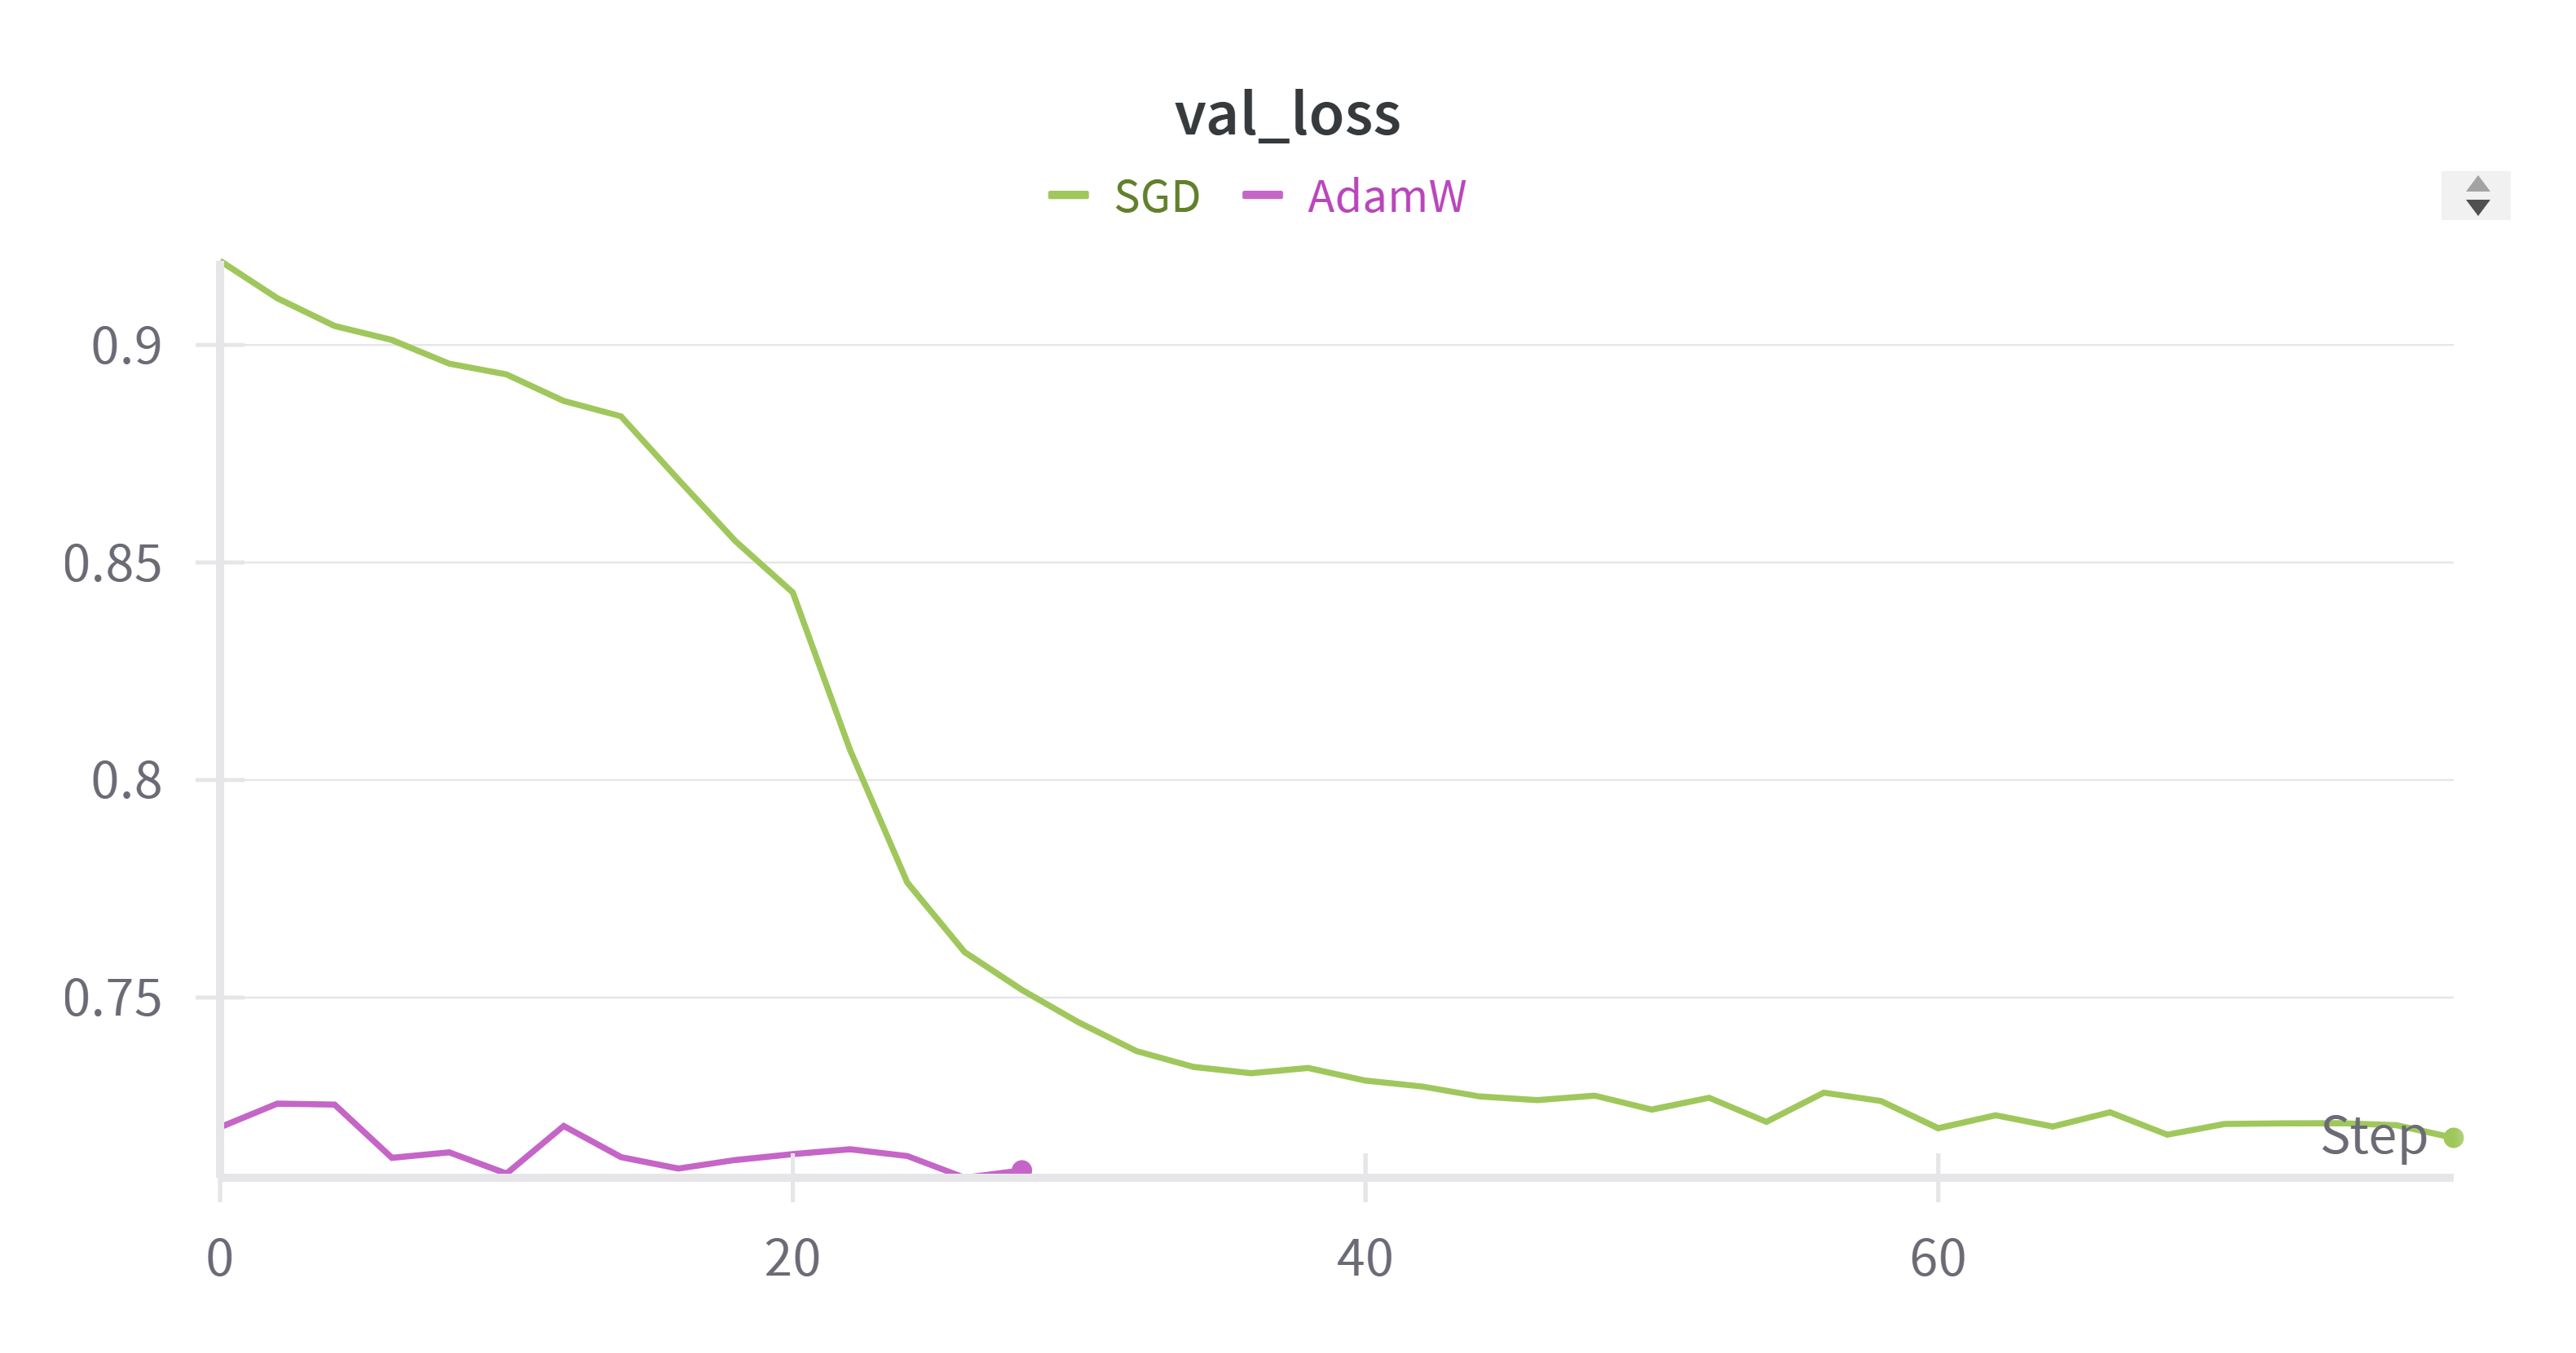

**Hloubka sítě**

Změny hloubky sítě neměly na kvalitu modelu příliš velký vliv. To pravděpodobně znamená, že všechna důležitá informace se nachází víceméně na úrovni pixelů samotných a z hlubších vrstev při downsamplingu už moc informace nezískáme. Při opakovaných pokusech dosahovaly všechny varianty modelu podobných výsledků.


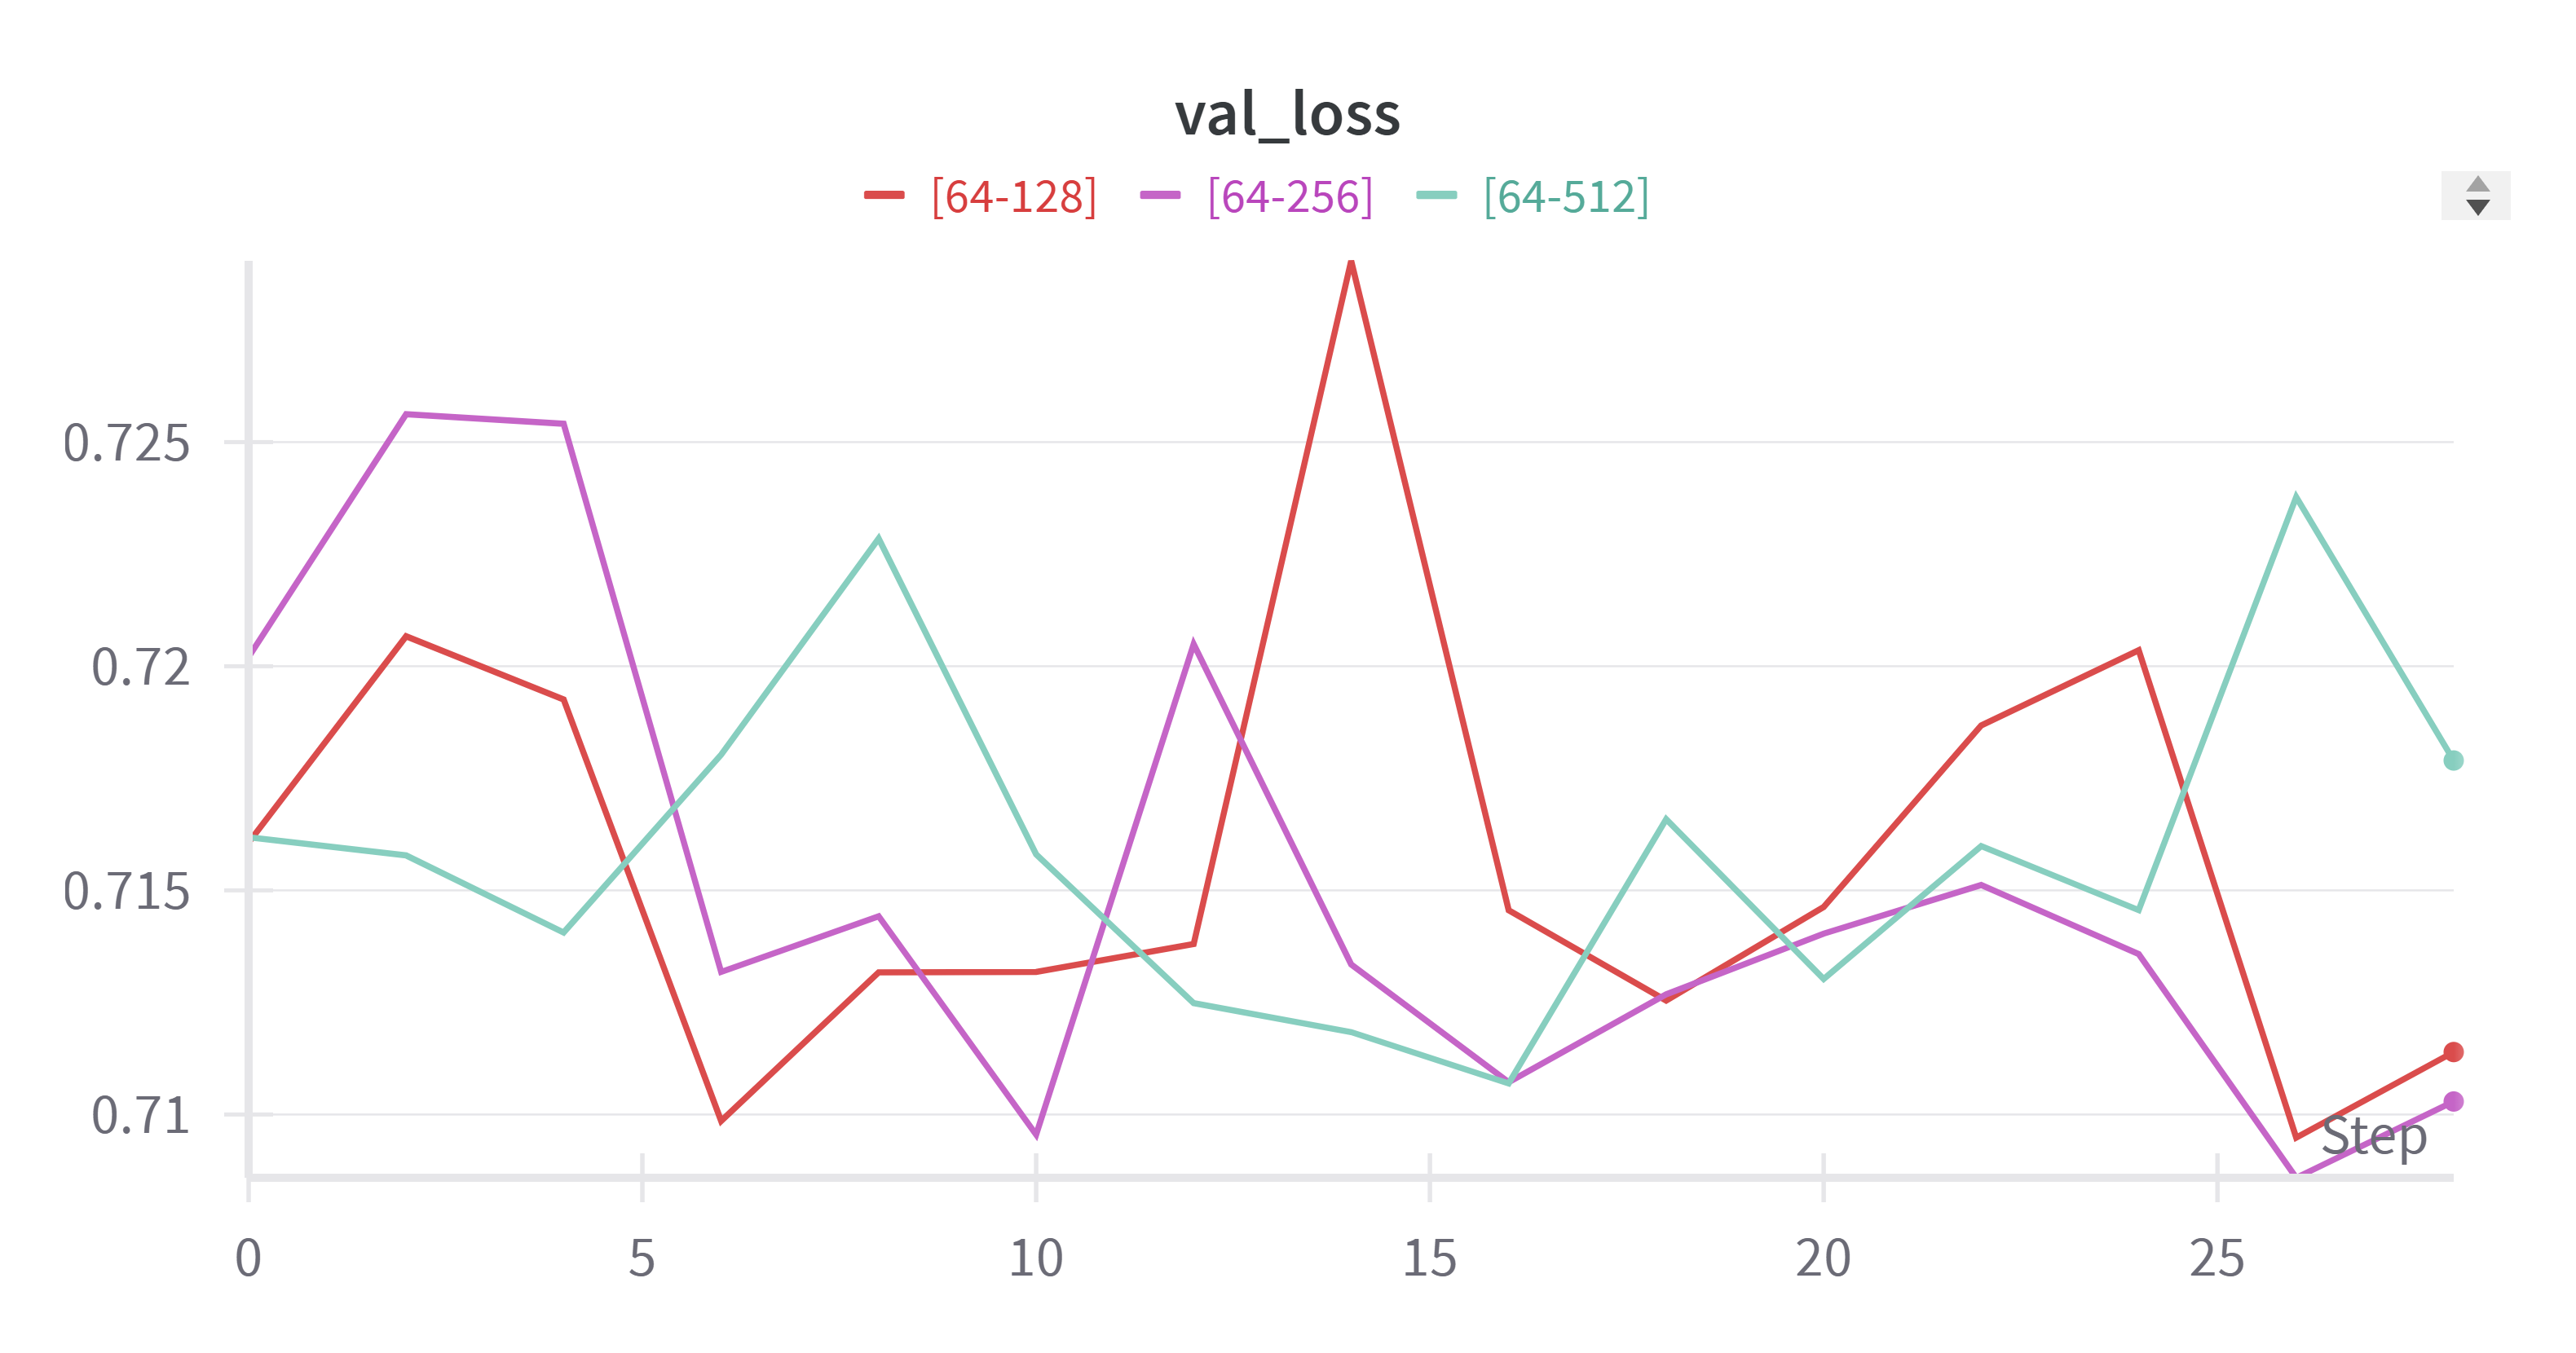

**Augmentace dat**

Již dříve jsme zmiňovali, že původní data jsou často centrovaná kolem výsledných požárů, pokud bychom tedy model trénovali na nezměněných datech, tuto vlastnost se naučí a bude téměř vždy predikovat požár ve středu dané oblasti, jak je vidět na obrázku níže.

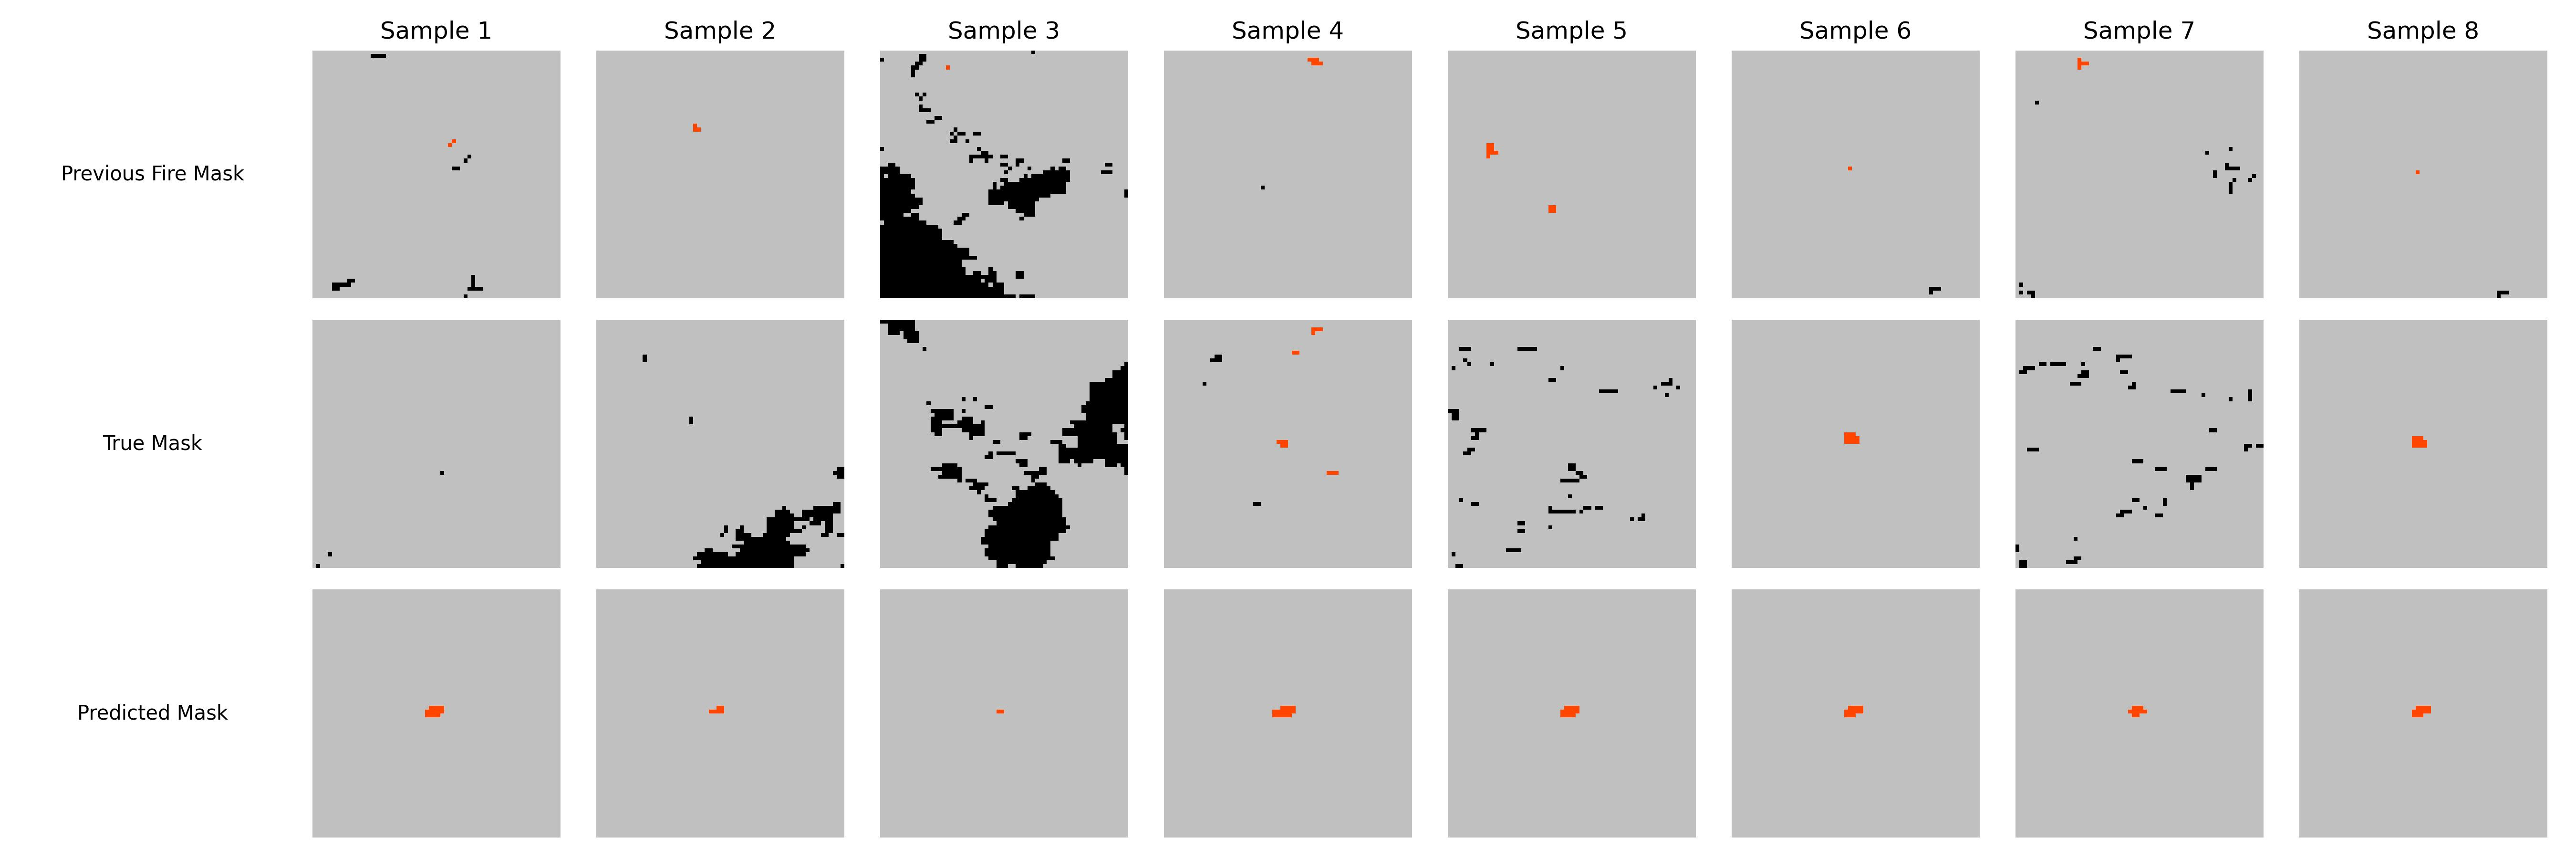

Abychom tomuto jevu zabránili, ořezáváme náhodně data na velikost 32x32. I tuto velikost můžeme brát jako hyperparametr a podívat se jak se model chová pro různá nastavení.

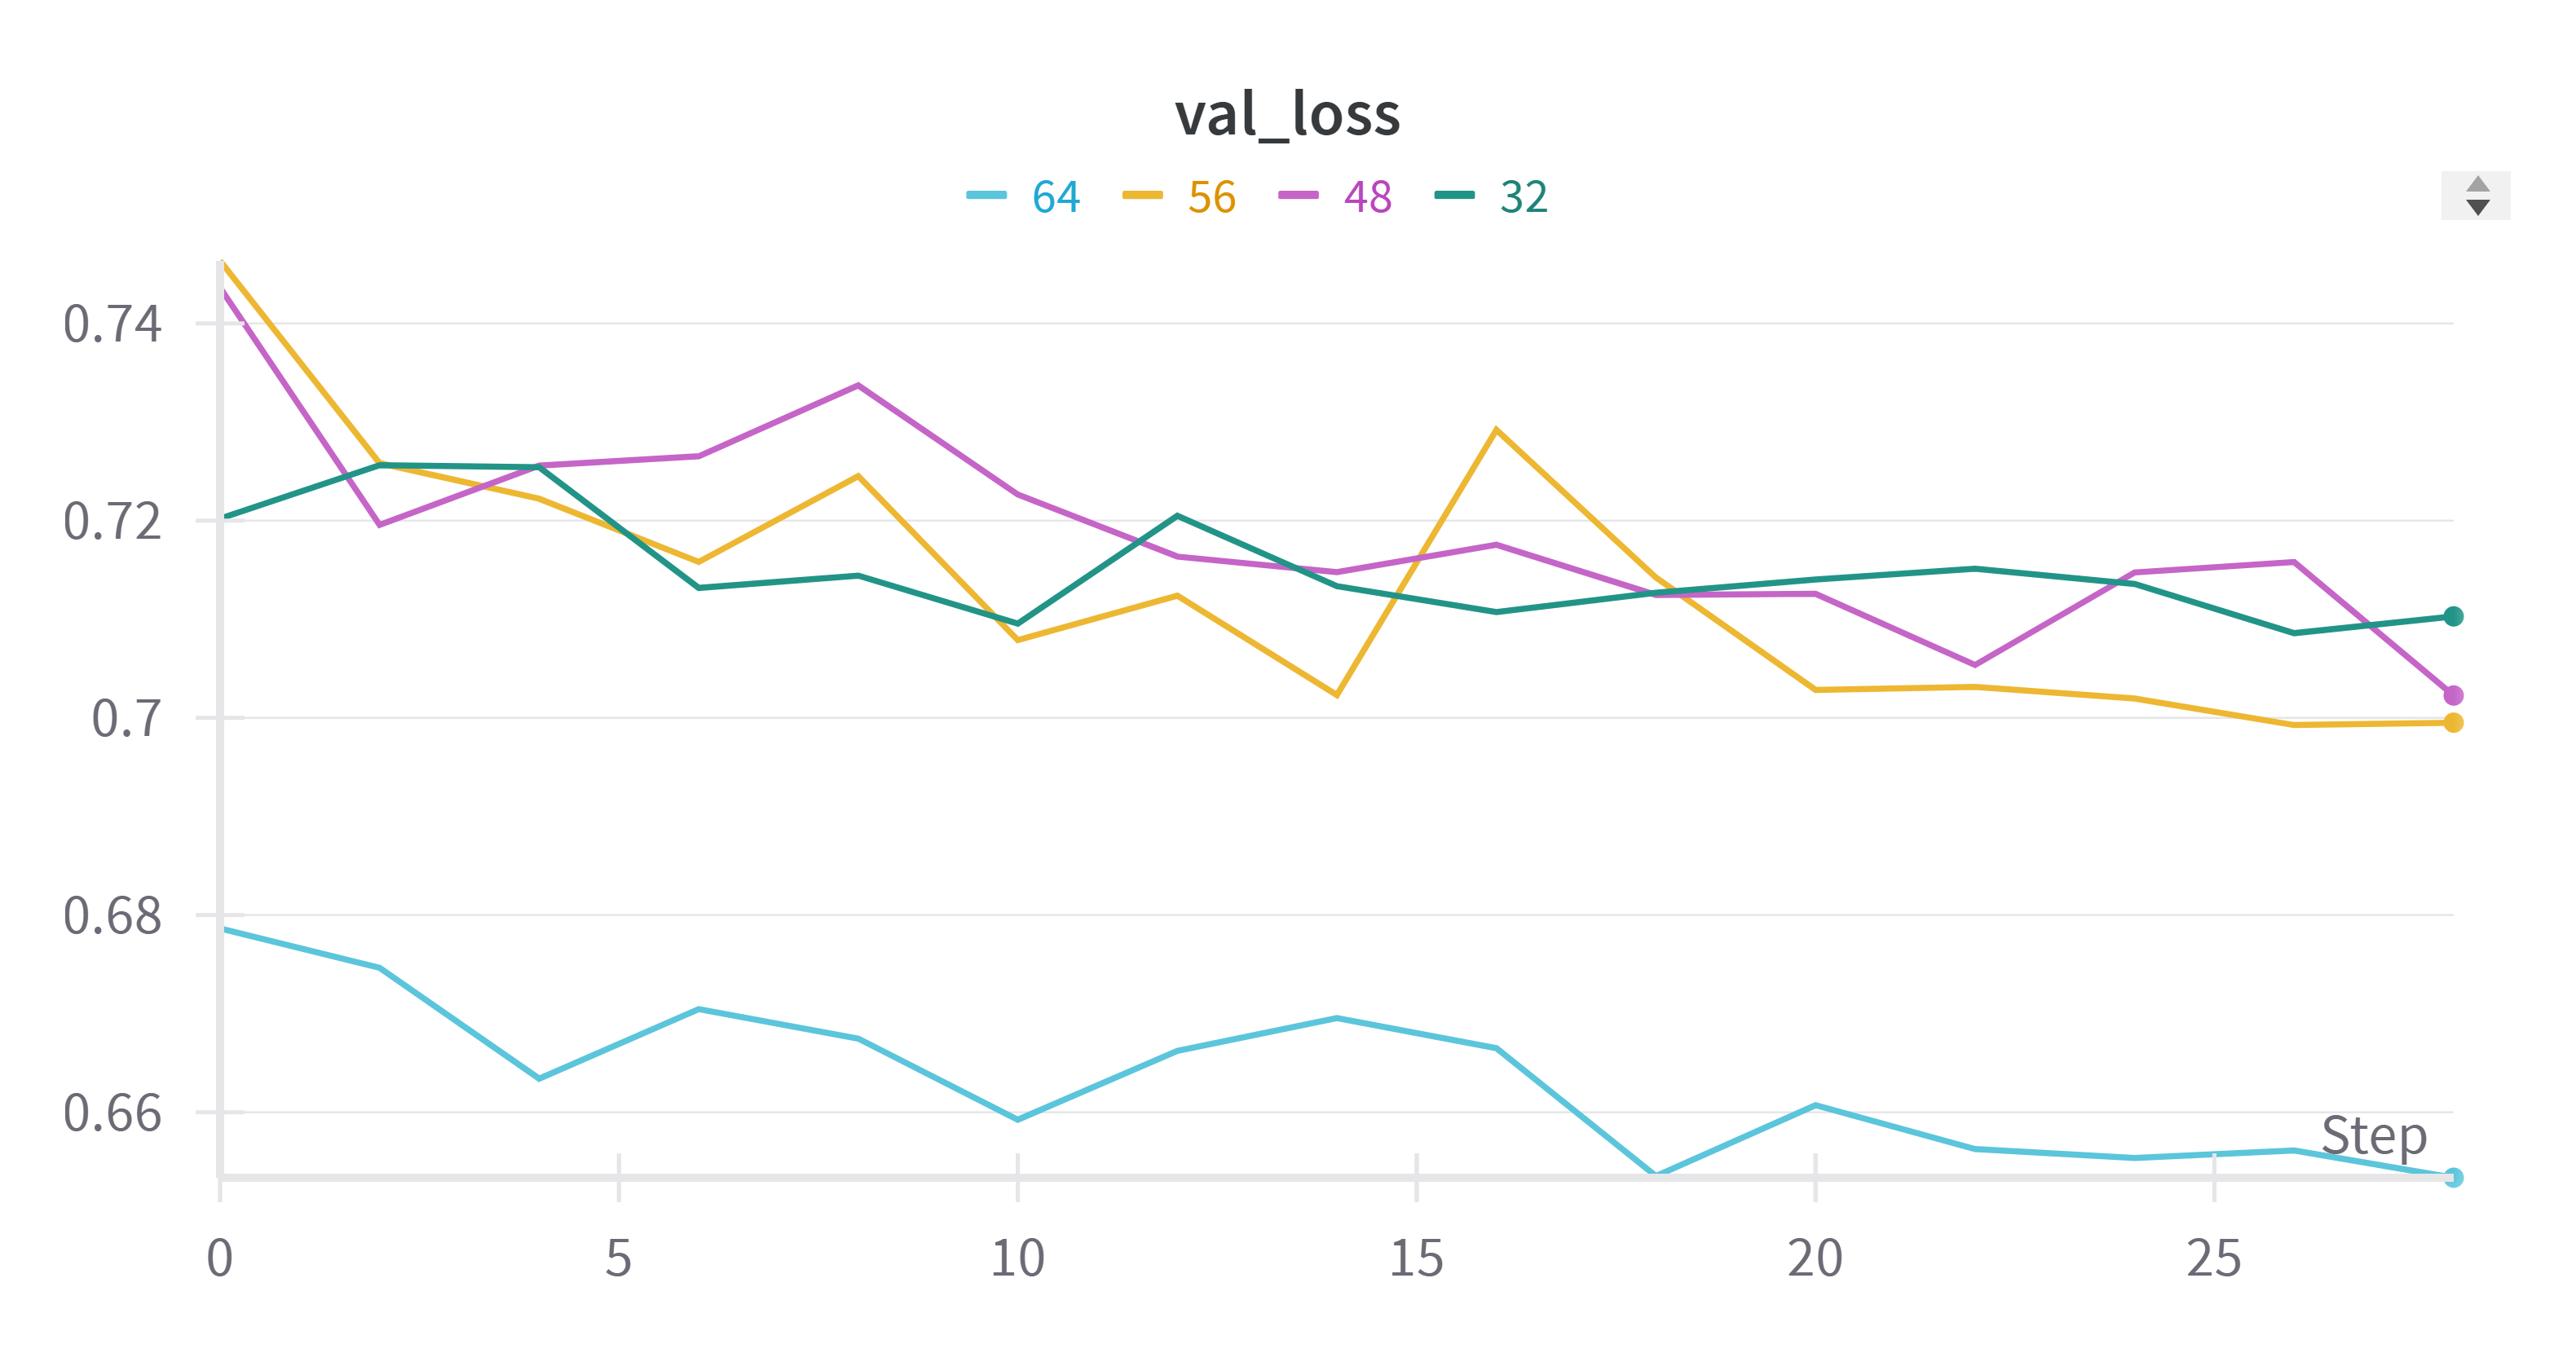

Z grafu výše je ale zřejmé, že hlavní rozdíl je v tom, zda data ořezáváme či nikoliv, velikost ořezu už zásadní roli nehraje. Stejně tak jsme vyzkoušeli i zrcadlení a otáčení dat, lepšího výsledku jsme ale nedosáhli.

**Další hyperparemetry**

Ani ostatní hyperparametry neměly na kvalitu příliš velký vliv, jejich finální volbu shrnuje následující tabulka.

| Hyperparametr           | Hodnota |
|------------------|-----------|
| batch size         | 16  |
| learning rate          | 0.001    |
| dropout        | 0.0|
| počet epoch    | 15|

##Závěr

Tento projekt se zabýval možností predikce šíření lesních požárů za použití satelitních dat a modelu U-Net. Přestože výsledky ukázaly, že šíření požárů s určitou mírou přesnosti lze předpovídat, narazili jsme na několik významných limitací, které kvalitu predikcí ovlivnily.

###Hlavní poznatky:


1.   **Charekter dat:** Velká variabilita a náhodnost šíření požárů, včetně přítomnosti malých a nespojitých ohnisek, zásadně ztěžuje jejich modelování. Dataset obsahující pouze jeden denní krok také omezil schopnost modelu rozpoznávat dlouhodobější vzorce.
2.   **Výkon modelu:** Síť U-Net dosahuje lepších výsledků než jednoduchá strategie založená na použití předchozí masky požáru. Nicméně v praktických aplikacích by byla potřeba vyšší úroveň přesnosti. Limitujícím faktorem je v tomto případě pravděpodobně nedostatečné množství informací v datech, nikoliv použitá architektura.
3.  **Vliv proměnných:** Prokázalo se, že informace z dálkového průzkumu Země zle využít ke zkvalitnění predikcí, oproti případu kdy bychom používali pouze masku požáru z předchozího dne.
4.  **Budoucí výzkum:** Pro naladění modelu vhodného pro aplikaci v praxi by bylo pravděpodobně potřeba vytvořit dataset obsahující vícedenní data pro zachycení dynamiky šíření požárů. Vyšší prostorové rozlišení by podle nás také mohlo přinést určité zlepšení.

##Reference

[F. Huot, R. L. Hu, N. Goyal, T. Sankar, M. Ihme, and Y.-F. Chen, “Next Day Wildfire Spread: A Machine Learning Data Set to Predict Wildfire Spreading from Remote-Sensing Data”, arXiv preprint, 2021.](https://arxiv.org/abs/2112.02447)